In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import gridspec
import numpy as np
import scipy
from scipy.interpolate import make_interp_spline
import pandas as pd

## README
Given the csv file `scores_csv` and a dictionary `id2dataset` which mapping dataset ids and dataset names, plot two analysis figures: (1) **the heatmap of Spearman Rank Correlation Coefficient**, demonstrating correlations between datasets with different models performance as variables, and (2) **the scatters of models performance** on each pair of datasets representing rolling and non-rolling for all levels.
### Input
- **scores_csv**: a csv file where the columns refer to the datasets and rows refer to the models and each cell indicates the  corresponding model performance.
- **id2dataset**: a dictionary that maps the dataset ids to the dataset names.
### The heatmap of Spearman Rank Correlation Coefficient
Spearman Rank Correlation Coefficient is a nonparametric measure of rank correlation (statistical dependence between the rankings of two variables). It assesses how well the relationship between two variables can be described using a monotonic function.

In this plot, we take the performance of all models on each dataset as variables and calculate the correlation coefficient between all pairs of datasets.
### The scatters of models performance
In each data level, there are a pair of datasets indicating rolling and non-rolling.

In this plot, we use the rolling and non-rolling datasets as horizontal and vertical coordinates to draw scatter plots of the different models on the corresponding datasets. We also show the fitting line in each scatter plot as well as the estimation error.

In [4]:
scores_csv = 'dataset_final_scores.csv'
id2dataset ={
    '1-1': '2_high_freq_ent',
    '1-2': '1_low_freq_ent',
    '1-3': 'r_1_simple_sample',
    '2-1': 'FewNERD',
    '2-2': 'DocRED',
    '2-3': 'COPEN++csj',
    '2-4': 'COPEN++cpj',
    '2-5': 'COPEN++cic',
    '2-6': 'MAVEN',
    '2-7': 'MAVEN-ERE',
    '2-8': 'r_DocRED',
    '3-1': 'hotpotqa',
    '3-2': '2wikimultihopqa',
    '3-3': 'musique',
    '3-4': 'kqapro',
    '3-5': 'KoRC++ood',
    '3-6': 'r_KoRC++ood',
    '4-1': 'Creating',
    '4-2': 'Rolling',
}

df = pd.read_csv(scores_csv)
df = df.iloc[:, 1:]

# change order
shifts_left = {'COPEN++csj':2,'COPEN++cpj':2,'COPEN++cic':2}
new_columns, dataset2id = [], {}
for i, c in enumerate(df.columns.tolist()):
    if c in shifts_left:
        new_columns.insert(len(new_columns)-shifts_left[c], c)
    else:
        new_columns.append(c)
_ind2datset = {i:k for i,(k,v) in enumerate(sorted(id2dataset.items(), key=lambda x:x[0]))}
dataset2id = {c:_ind2datset[i] for i,c in enumerate(new_columns)}

df = df.reindex(columns=new_columns)
# dataset2id = {v:k for k,v in id2dataset.items()} # do not change
df_id = df.rename(dataset2id, axis='columns')
# print(df.columns)
# print(df_id.columns)

# dataset_names = df.columns
# model_ids = df.iloc[:,0].to_numpy()

# data = df.to_numpy()

## Spearman Rank Correlation Coefficient

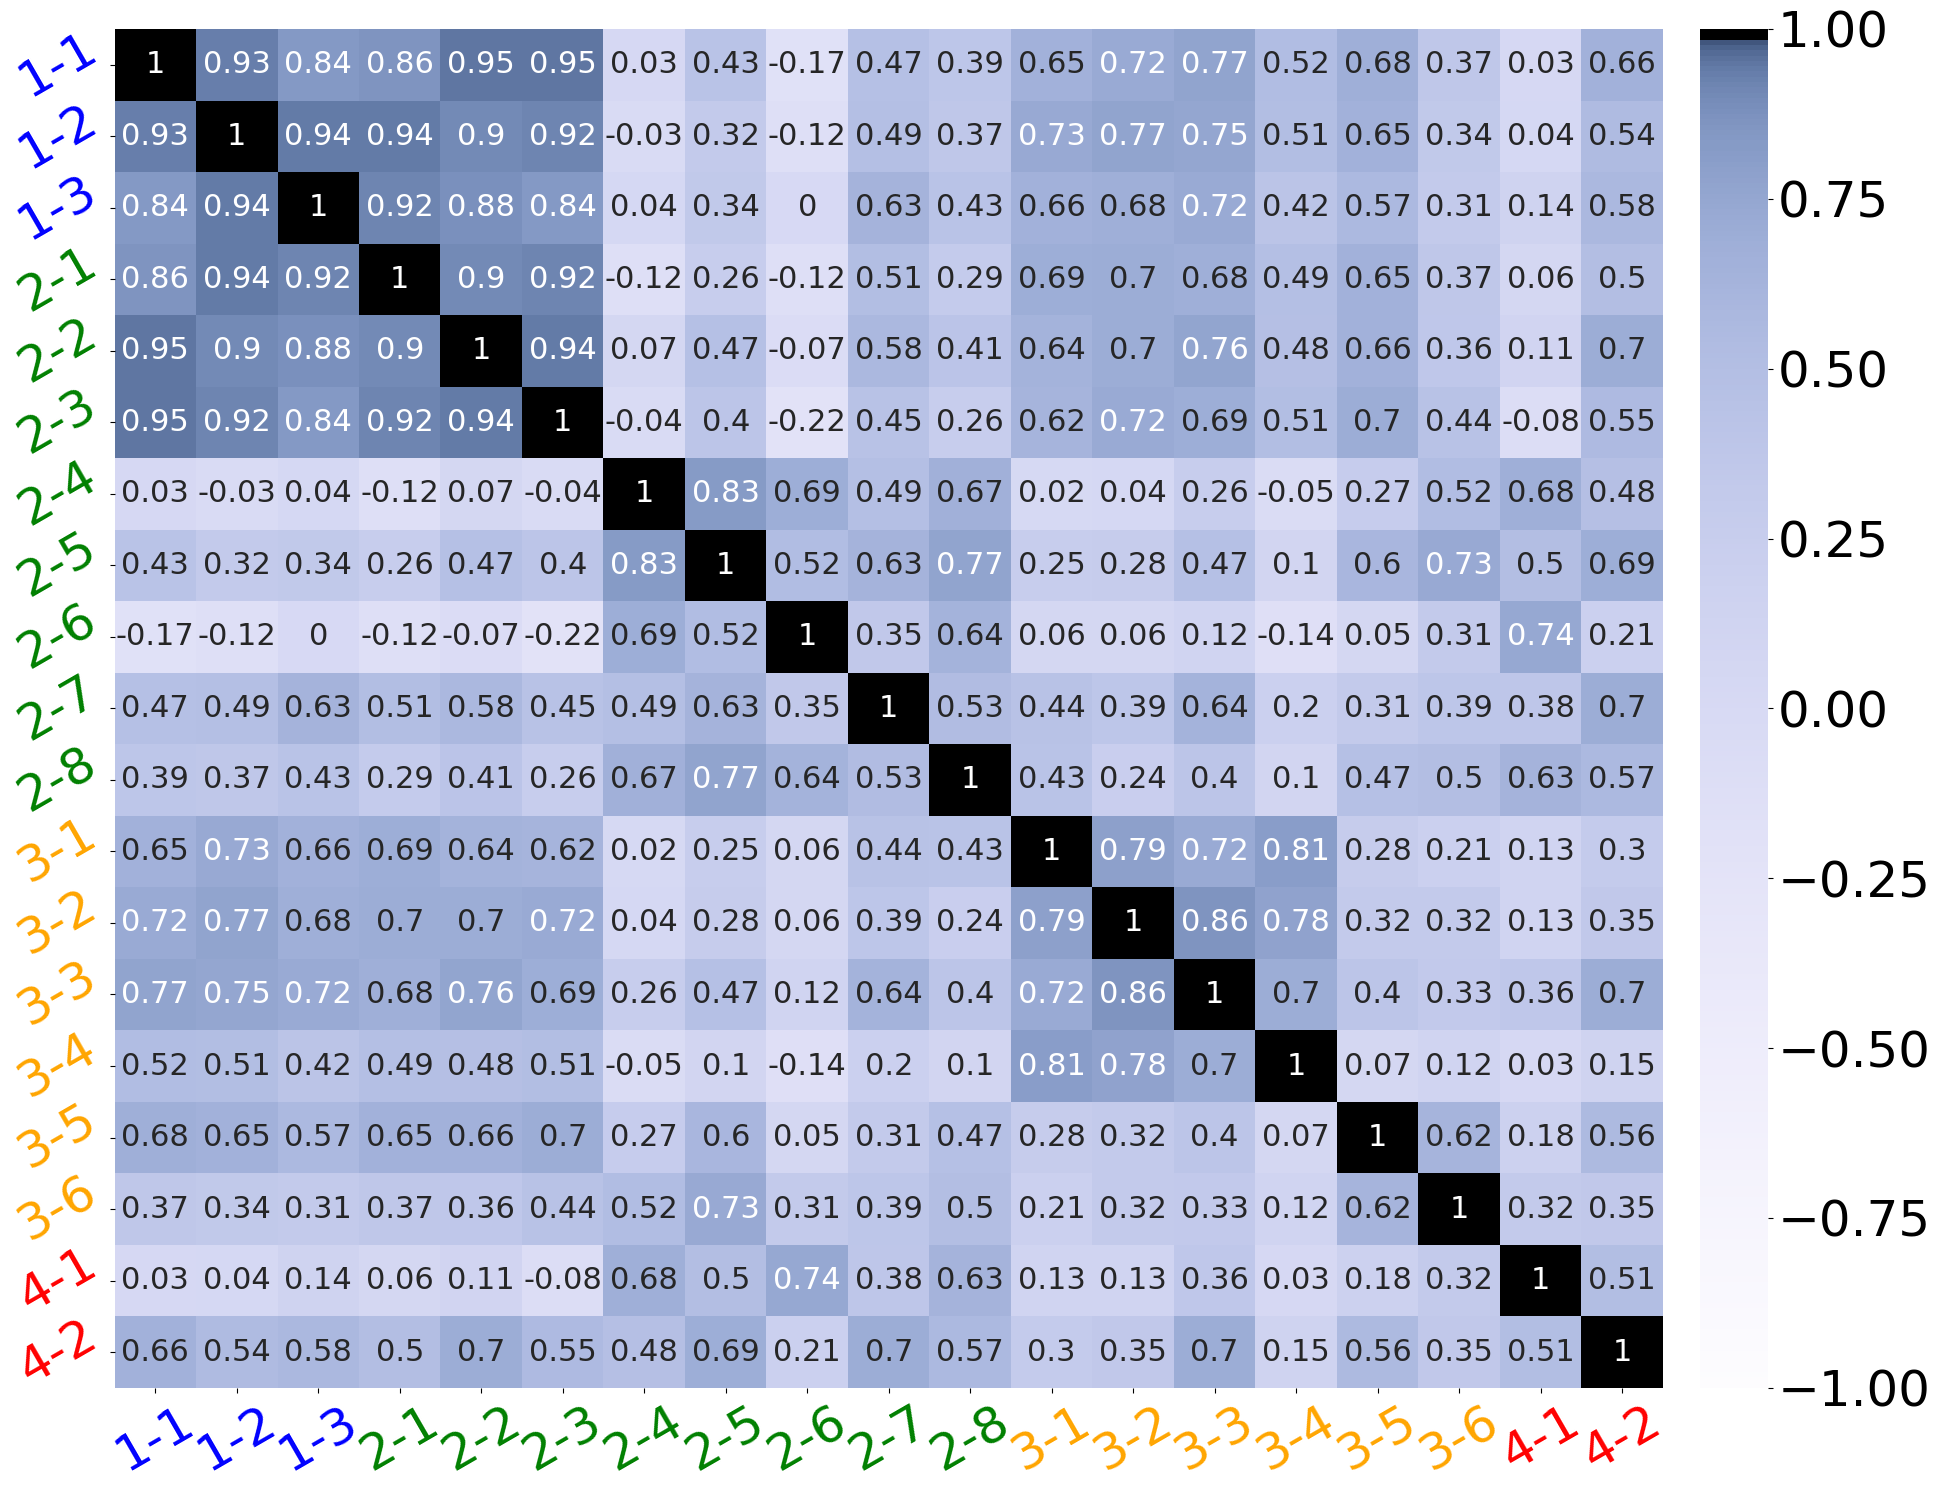

In [5]:
# Plot Spearman Rank Correlation Coefficient
spr_scores = df_id.corr(method='spearman').round(2)

fig, ax = plt.subplots(figsize=(20,15))
colormap = sns.cubehelix_palette(start=2.8, rot=0.1, gamma=0.2, dark=-0.0, light=0.95, as_cmap=True)
hs = sns.heatmap(spr_scores, vmin=-1, vmax=1, annot=True, annot_kws={'size':22}, cmap=colormap, cbar_kws={"pad":0.02})
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=36)

# ax.set_title('Spearman\'s ρ between datasets with model performance as variables', fontsize=20)
ax.tick_params(labelsize=36, rotation=30)
colors=['blue']*3 + ['green']*8 + ['orange']*6 + ['red']*2
[t.set_color(colors[i]) for i,t in enumerate(ax.xaxis.get_ticklabels())]
[t.set_color(colors[i]) for i,t in enumerate(ax.yaxis.get_ticklabels())]
plt.tight_layout()
fig.savefig('spearman_rho_datasets.pdf')
# heatmap.set_title('Spearman\'s ρ between datasets with model performance as variables')

## Scatters (MultipleLines)

In [6]:
def display_scatter_multilines(Xs, Ys, names=None, xlabels=None, ylabels=None, xlim=None, ylim=None,
                               titles=None, save_name=None, fit='polyfit'):
    
    titles = titles if titles is not None else [""]*len(Xs)
    xlabels = xlabels if xlabels is not None else [""]*len(Xs)
    ylabels = ylabels if ylabels is not None else [""]*len(Xs)
    cols = 2
    rows = len(Xs) // 2
    fig, axes = plt.subplots(rows, cols, figsize=(20,15), tight_layout=True)
    if cols <= 1:
        axes = np.array([axes])
        
    for i, (X,Y) in enumerate(zip(Xs,Ys)):
        r, c = i // rows, i % rows
        title = titles[i] if titles is not None else None
        axes[r,c].set_title(title, fontsize=30)
        axes[r,c].set_xlabel(xlabels[i], fontsize=16)
        axes[r,c].set_ylabel(ylabels[i], fontsize=16)
        axes[r,c].xaxis.set_minor_locator(MultipleLocator(1))
        if xlim is not None: axes[r,c].set_xlim(xlim)
        if ylim is not None: axes[r,c].set_ylim(ylim)
#         axes[i].scatter(X, Y, s=25, c="#9370DB", alpha=0.5)
        axes[r,c].scatter(X, Y, c='gray', marker='o', edgecolors='k', s=40)
#         axes[i].set_yticks(np.unique(Y))
        # annotate points
        if names:
            for i in range(len(X)):
                plt.annotate(names[i], xy=(X[i],Y[i]), xytext=(X[i]-0.5,Y[i]+0.8), fontsize=6)
        axes[r,c].grid(alpha=0.2)
        axes[r,c].tick_params(labelsize=36)
        
        # Fit
        if fit != '':
            p = np.polyfit(X, Y, 1) # # p[0]=Gradient, p[1]=y-intercept
            model = np.poly1d(p)
            # Fit the model
            y_model = model(X)
            
            # Number of observations
            n = Y.size
            # Number of parameters: equal to the degree of the fitted polynomial (ie the
            # number of coefficients) plus 1 (ie the number of constants)
            m = p.size
            # Degrees of freedom (number of observations - number of parameters)
            dof = n - m
            # Significance level
            alpha = 0.05
            # We're using a two-sided test
            tails = 2
            # The percent-point function (aka the quantile function) of the t-distribution
            # gives you the critical t-value that must be met in order to get significance
            t_critical = scipy.stats.t.ppf(1 - (alpha / tails), dof)
            # Mean
            y_bar = np.mean(Y)
            # Coefficient of determination, R²
            R2 = np.sum((y_model - y_bar)**2) / np.sum((Y - y_bar)**2)
            
            # Calculate the residuals (the error in the data, according to the model)
            resid = Y - y_model
            # Chi-squared (estimates the error in data)
            chi2 = sum((resid / y_model)**2)
            # Reduced chi-squared (measures the goodness-of-fit)
            chi2_red = chi2 / dof
            # Standard deviation of the error
            std_err = np.sqrt(sum(resid**2) / dof)

            xlim = axes[r,c].get_xlim()
            ylim = axes[r,c].get_ylim()
            # Line of best fit
            axes[r,c].plot(np.array(xlim), p[1] + p[0] * np.array(xlim), label=f'Line of Best Fit, R² = {R2:.2f}')
            
            # Fit
            x_fitted = np.linspace(xlim[0], xlim[1], 300)
            y_fitted = np.polyval(p, x_fitted)
            # Confidence interval
            ci = t_critical * std_err * np.sqrt(1 / n + (x_fitted - np.mean(X))**2 / np.sum((X - np.mean(X))**2))
            axes[r,c].fill_between(
                x_fitted, y_fitted + ci, y_fitted - ci, facecolor='#b9cfe7', zorder=0,
                label=r'95% Confidence Interval'
            )
            axes[r,c].legend(fontsize=32, loc='upper left')
    
    # ax = plt.gca()
    # ax.set_yticks(Ys[0])
    plt.tight_layout()
    if save_name:
        fig.savefig(save_name, dpi=400)
    plt.show()

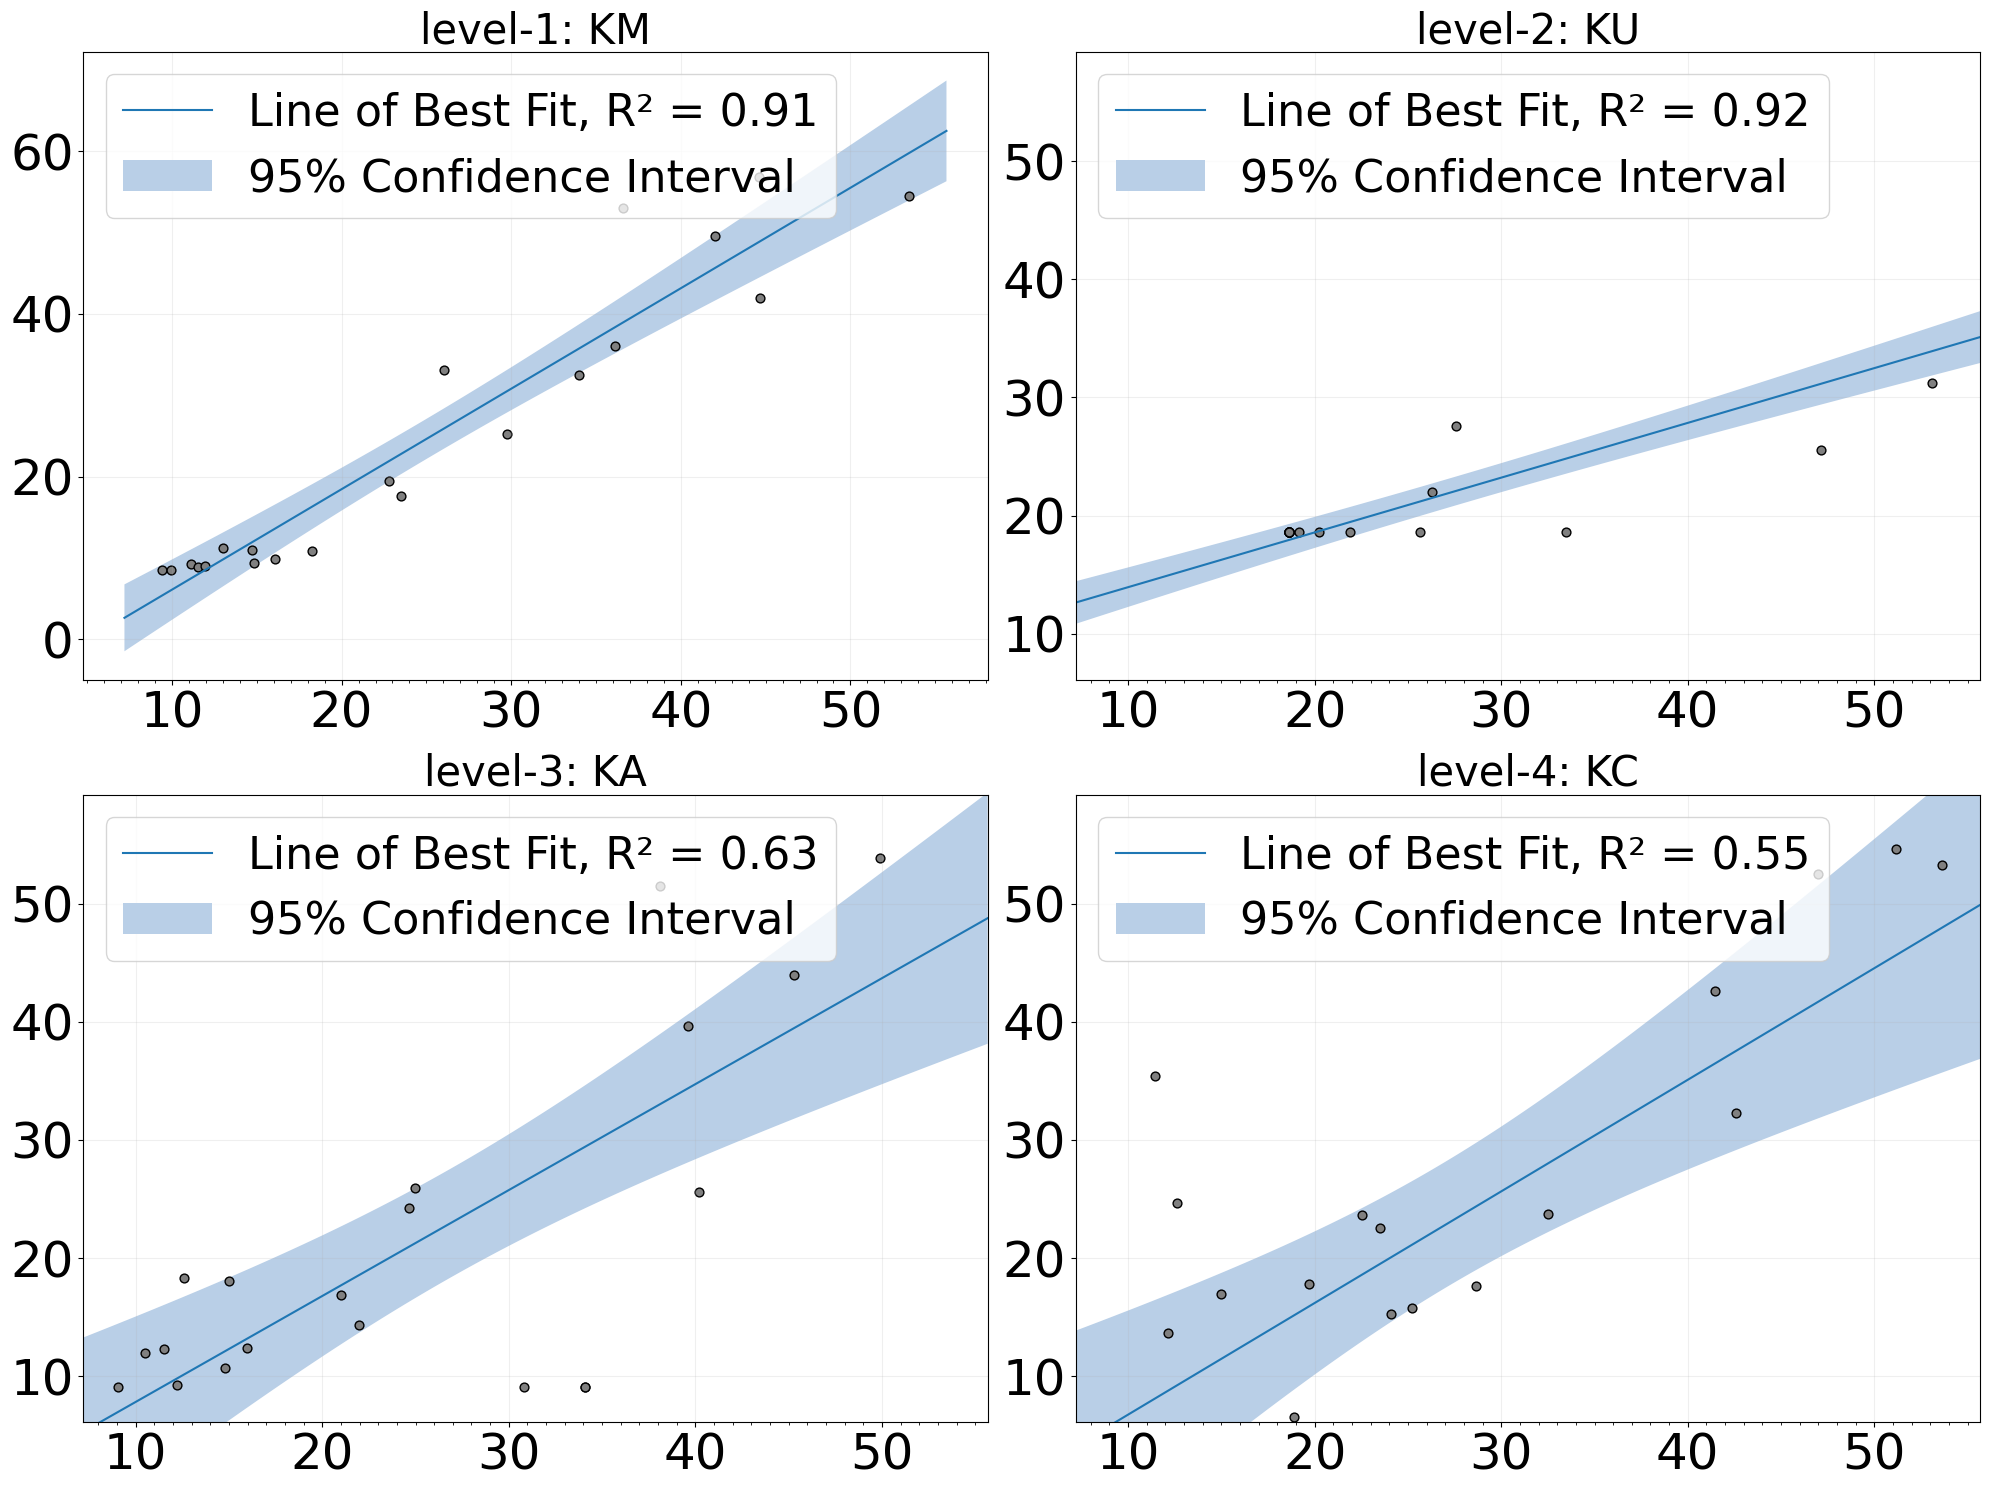

In [7]:
Xs = [(df['2_high_freq_ent'] + df['1_low_freq_ent']) / 2, df['DocRED'], df['KoRC++ood'], df['Creating']]
Ys = [df['r_1_simple_sample'], df['r_DocRED'], df['r_KoRC++ood'], df['Rolling']]
display_scatter_multilines(Xs, Ys, titles=['level-1: KM', 'level-2: KU', 'level-3: KA', 'level-4: KC'], save_name='scatters_all.pdf')